In [2]:
#importing necessary libraries
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve,auc,classification_report,confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score,f1_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from matplotlib_venn import venn3,venn3_circles
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

In [4]:
#reading csv file into dataframe
df = pd.read_csv('data_mobile_price_range.csv')

In [5]:
#rows and columns of dataframe
df.shape

(2000, 21)

In [6]:
#sample of dataset
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

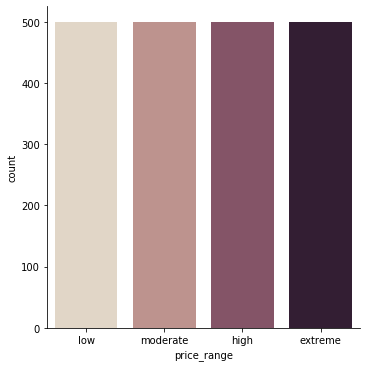

In [8]:
sns.catplot(x="price_range", kind="count", palette="ch:.25", data=df)
plt.xticks(ticks=[0,1,2,3],labels = ['low','moderate','high','extreme'])
plt.show()

In [9]:
df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range'], dtype='object')

In [10]:
df.columns = ['battery_power', 'bluetooth', 'clock_speed', 'dual_sim', 'front_cam', '4G', 'ROM',
              'depth', 'weight', 'cores', 'rear_cam', 'resol_height', 'resol_width', 'RAM', 'height', 
              'width', 'talk_time', '3G', 'touch_screen', 'wifi', 'price_range']

In [11]:
print('\033[1m' + 'Column \t\t No.of unique values')
print('\033[0m')
for i in df:
    print(i,' '*(13-len(i)),'\t',df[i].nunique())

Column 		 No.of unique values

battery_power  	 1094
bluetooth      	 2
clock_speed    	 26
dual_sim       	 2
front_cam      	 20
4G             	 2
ROM            	 63
depth          	 10
weight         	 121
cores          	 8
rear_cam       	 21
resol_height   	 1137
resol_width    	 1109
RAM            	 1562
height         	 15
width          	 19
talk_time      	 19
3G             	 2
touch_screen   	 2
wifi           	 2
price_range    	 4


In [12]:
dependent = 'price_range'
independent = list(set(df.columns) - {dependent})
categorical = []
print('\033[1m' + 'Categorical Variables\t\tUnique Values' + '\033[0m')
for i in independent:
    if df[i].nunique()<10:
        categorical.append(i)
        print(i,' '*(12-len(i)),'\t\t\t',df[i].unique())
numerical = list(set(df.columns) - set(categorical)- {dependent})

Categorical Variables		Unique Values
bluetooth     			 [0 1]
cores         			 [2 3 5 6 1 8 4 7]
3G            			 [0 1]
wifi          			 [1 0]
4G            			 [0 1]
dual_sim      			 [0 1]
touch_screen  			 [0 1]


In [13]:
df.describe()

,battery_power,bluetooth,clock_speed,dual_sim,front_cam,4G,ROM,depth,weight,cores,rear_cam,resol_height,resol_width,RAM,height,width,talk_time,3G,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


# Data Cleaning

resolution height and width got minimum values as zero

Let us check how many values are zeroes there

In [14]:
df[df['width']==0].shape[0]

180

In [15]:
df[df['resol_height']==0].shape[0]

2

In [16]:
df = df[df['resol_height']!=0]

In [17]:
df['width'] = df['width'].replace(0, np.nan)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  1998 non-null   int64  
 1   bluetooth      1998 non-null   int64  
 2   clock_speed    1998 non-null   float64
 3   dual_sim       1998 non-null   int64  
 4   front_cam      1998 non-null   int64  
 5   4G             1998 non-null   int64  
 6   ROM            1998 non-null   int64  
 7   depth          1998 non-null   float64
 8   weight         1998 non-null   int64  
 9   cores          1998 non-null   int64  
 10  rear_cam       1998 non-null   int64  
 11  resol_height   1998 non-null   int64  
 12  resol_width    1998 non-null   int64  
 13  RAM            1998 non-null   int64  
 14  height         1998 non-null   int64  
 15  width          1819 non-null   float64
 16  talk_time      1998 non-null   int64  
 17  3G             1998 non-null   int64  
 18  touch_sc

In [19]:
from sklearn.impute import KNNImputer

In [20]:
imputer = KNNImputer(n_neighbors=1)

In [21]:
df = pd.DataFrame(imputer.fit_transform(df),columns=df.columns)

In [22]:
df.shape

(1998, 21)

In [23]:
df.head()

,battery_power,bluetooth,clock_speed,dual_sim,front_cam,4G,ROM,depth,weight,cores,rear_cam,resol_height,resol_width,RAM,height,width,talk_time,3G,touch_screen,wifi,price_range
0,842.0,0.0,2.2,0.0,1.0,0.0,7.0,0.6,188.0,2.0,2.0,20.0,756.0,2549.0,9.0,7.0,19.0,0.0,0.0,1.0,1.0
1,1021.0,1.0,0.5,1.0,0.0,1.0,53.0,0.7,136.0,3.0,6.0,905.0,1988.0,2631.0,17.0,3.0,7.0,1.0,1.0,0.0,2.0
2,563.0,1.0,0.5,1.0,2.0,1.0,41.0,0.9,145.0,5.0,6.0,1263.0,1716.0,2603.0,11.0,2.0,9.0,1.0,1.0,0.0,2.0
3,615.0,1.0,2.5,0.0,0.0,0.0,10.0,0.8,131.0,6.0,9.0,1216.0,1786.0,2769.0,16.0,8.0,11.0,1.0,0.0,0.0,2.0
4,1821.0,1.0,1.2,0.0,13.0,1.0,44.0,0.6,141.0,2.0,14.0,1208.0,1212.0,1411.0,8.0,2.0,15.0,1.0,1.0,0.0,1.0


# Exploratory Data Analysis

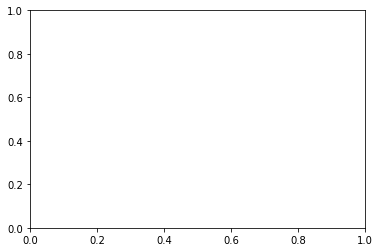

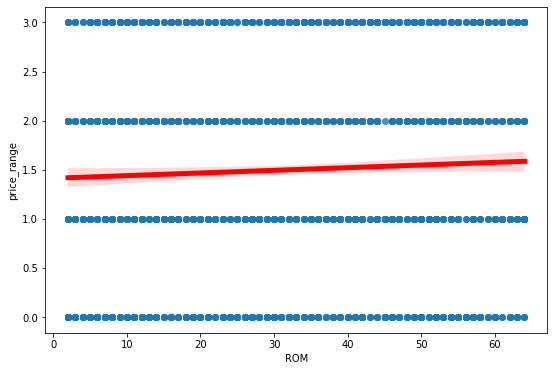

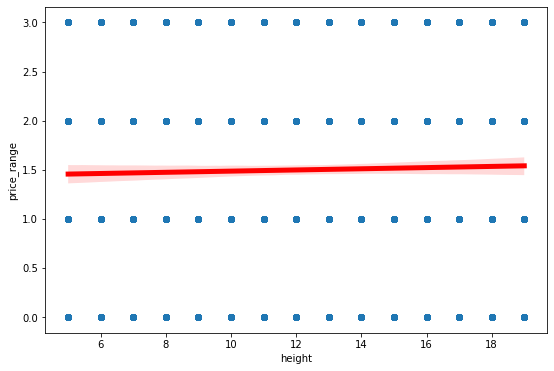

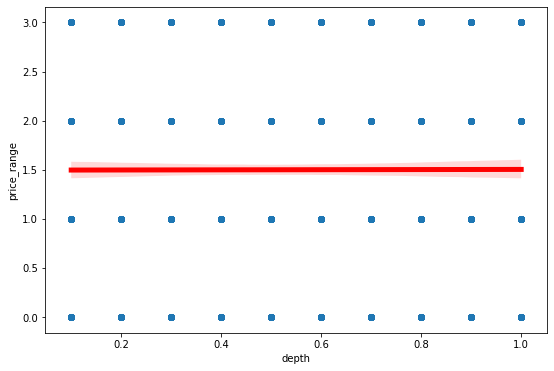

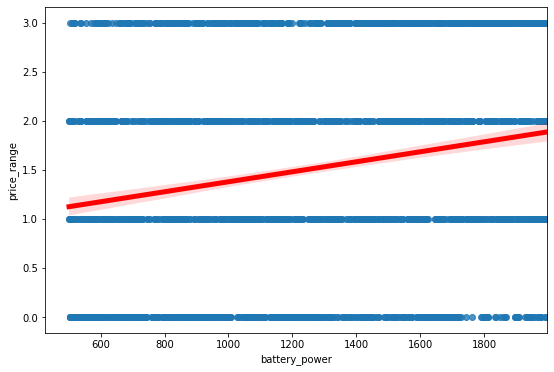

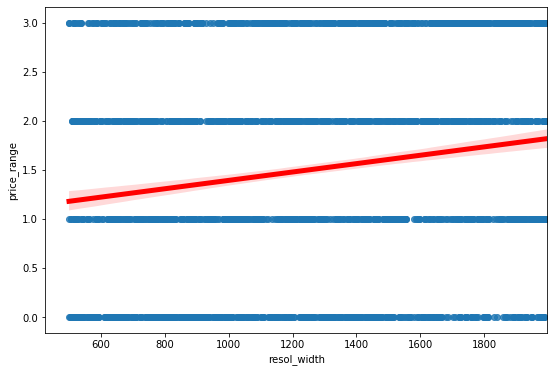

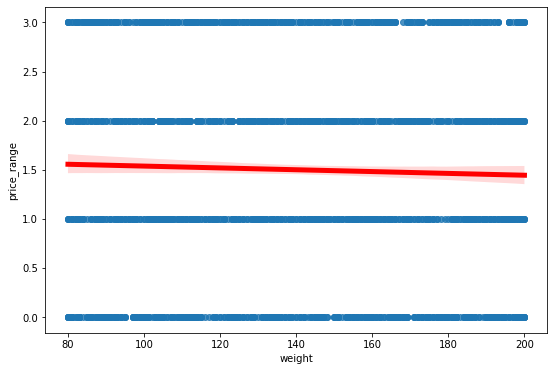

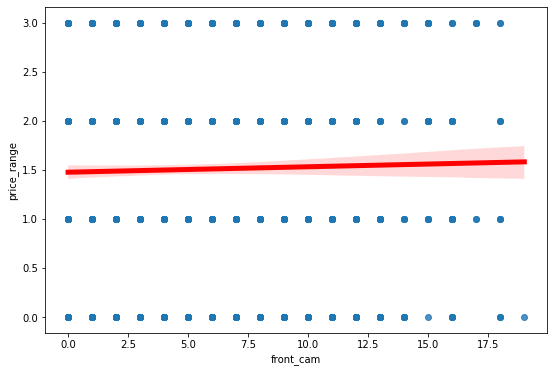

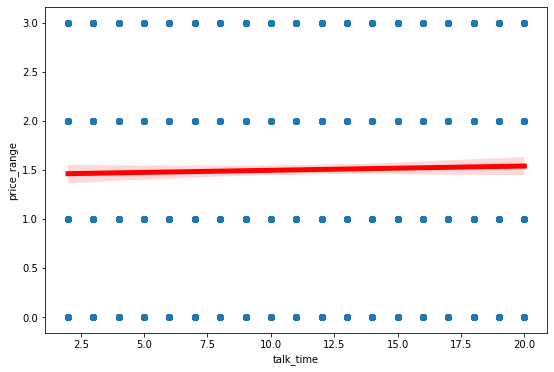

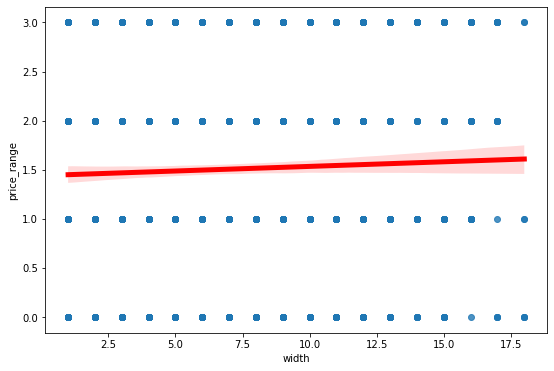

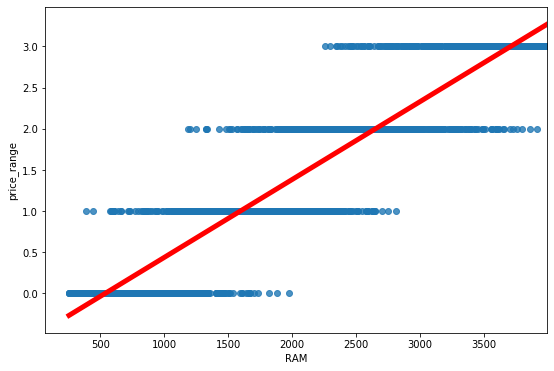

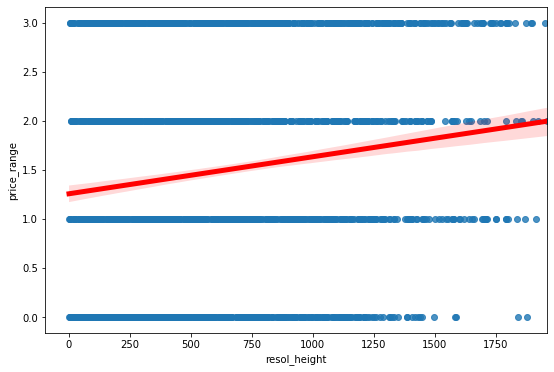

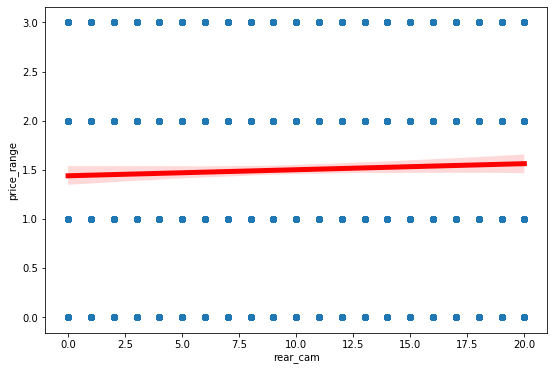

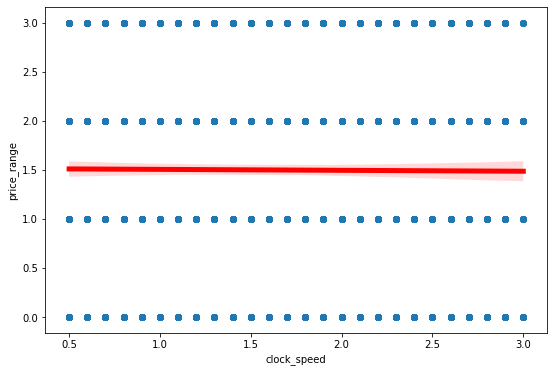

In [25]:
fig,axes = plt.subplots()
for i in numerical:
    fig = plt.figure(figsize=(9, 6))
    sns.regplot(x = i, y = 'price_range', data = df,line_kws={'lw': 5, 'color': 'red'})
    plt.show()

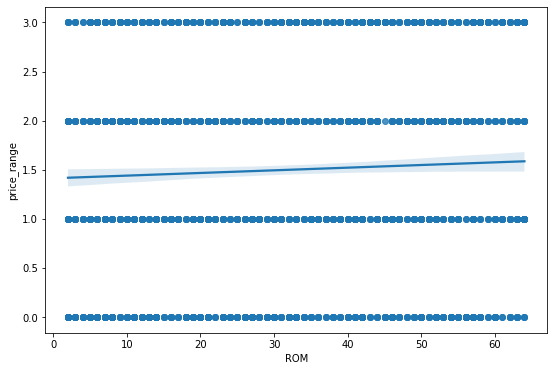

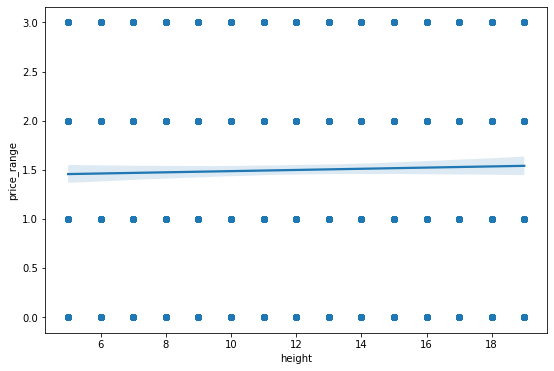

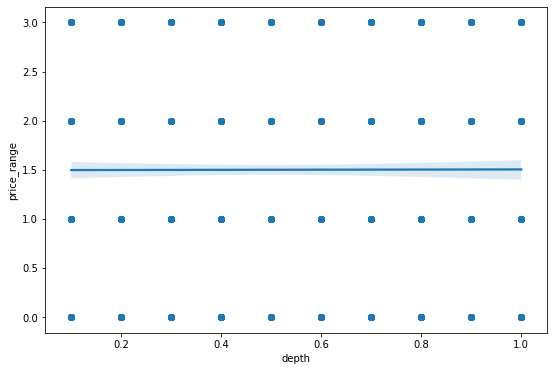

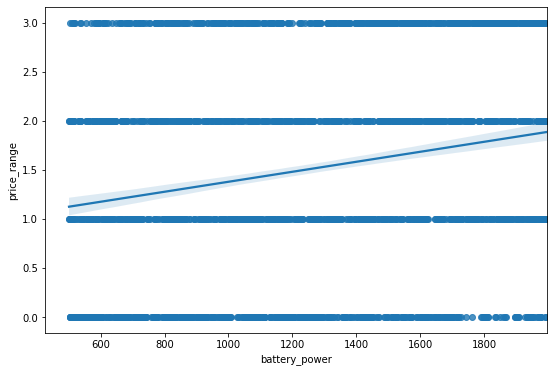

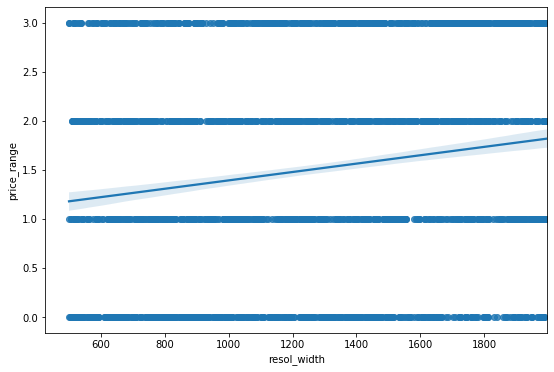

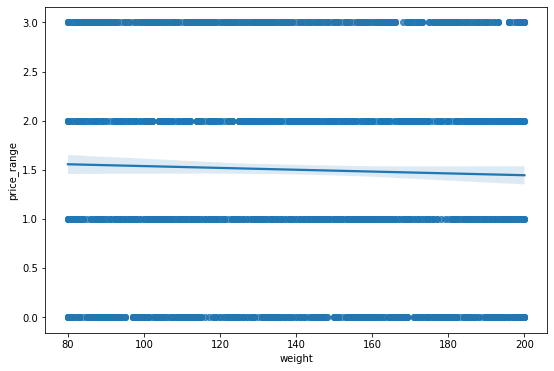

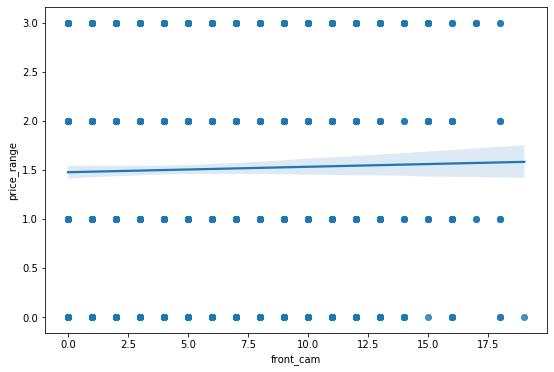

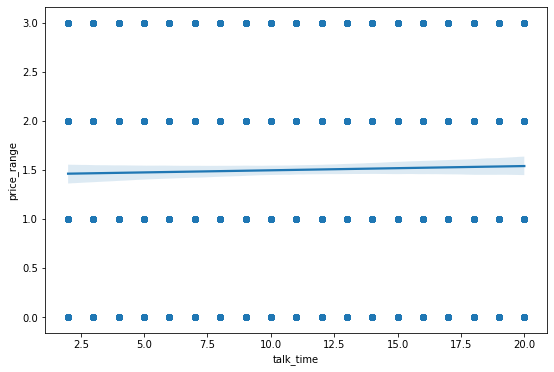

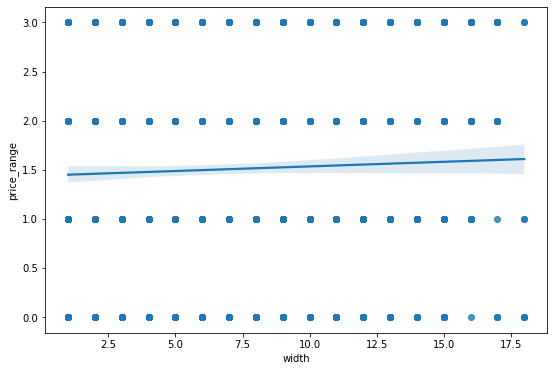

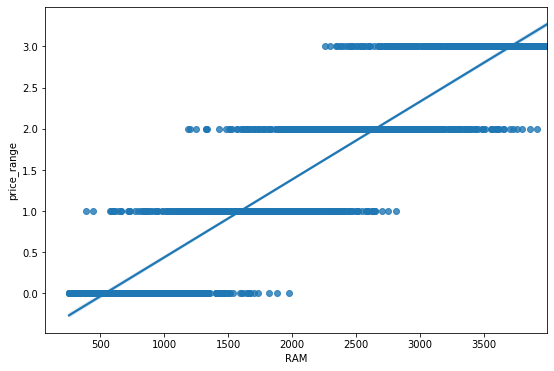

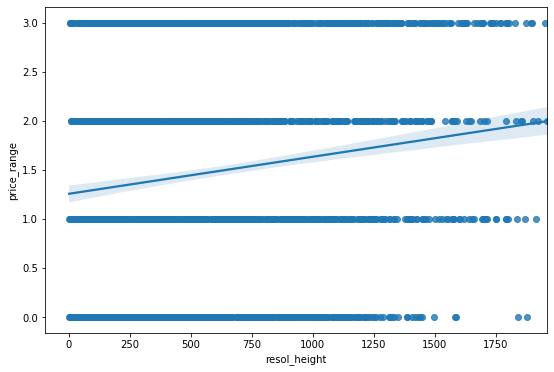

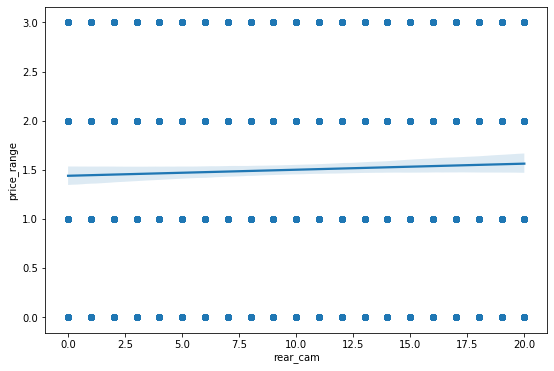

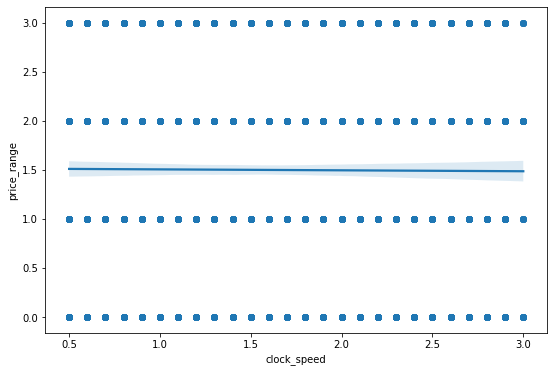

In [24]:
for i in numerical:
    fig = plt.figure(figsize=(9, 6))
    sns.regplot(x = i, y = 'price_range', data = df)
    plt.show()

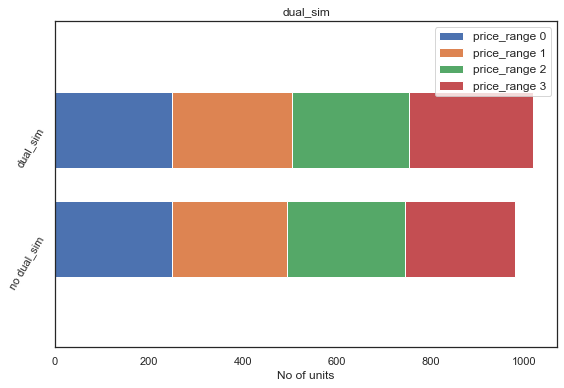

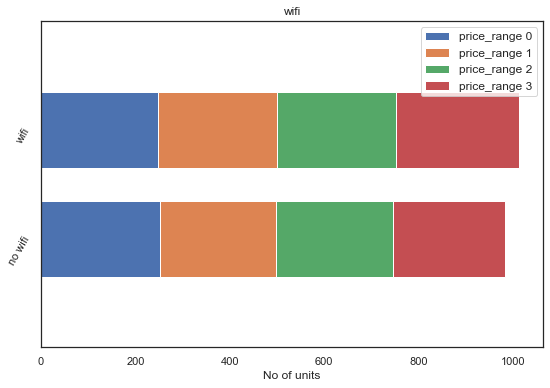

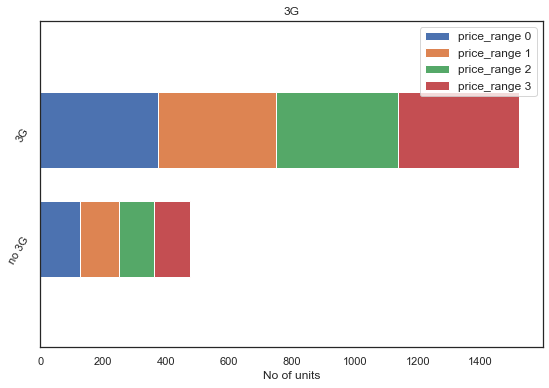

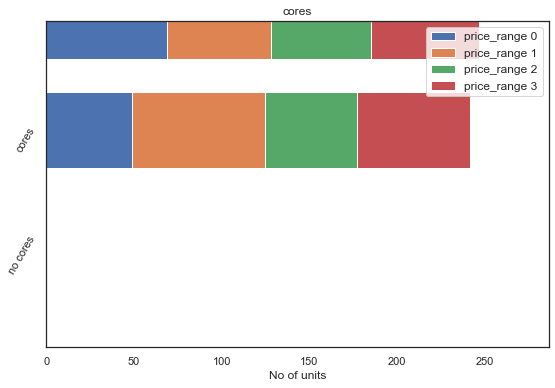

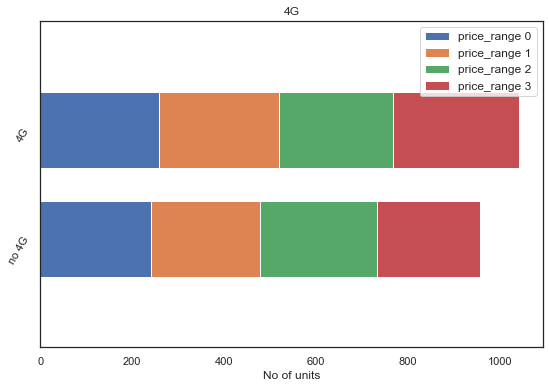

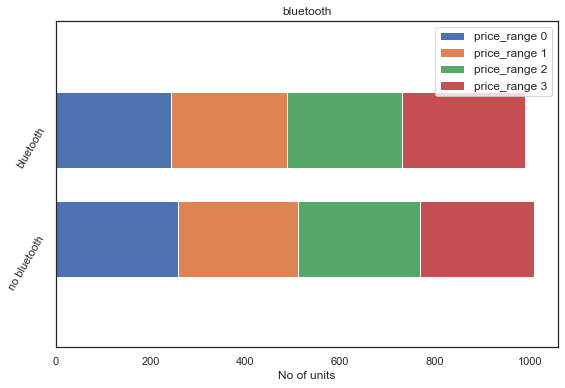

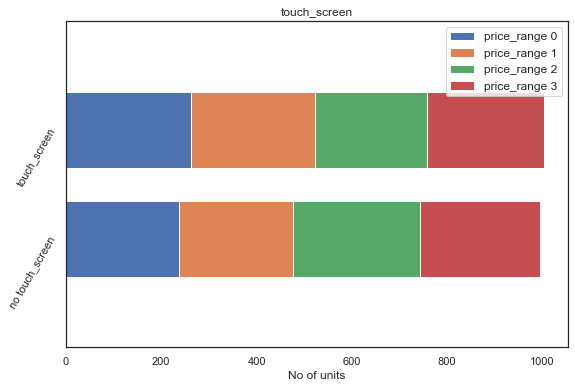

In [633]:
# Creating df according to price_range
df_0 = df[df['price_range'] == 0]
df_1 = df[df['price_range'] == 1]
df_2 = df[df['price_range'] == 2]
df_3 = df[df['price_range'] == 3]

sns.set_theme(style='white',palette='deep')

# Creating stacked bar charts for each categorical feature wrt price range
for col in categorical:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  plt.barh(sorted(df_0[col].unique()), df_0[col].value_counts().sort_index(), height=0.7, label= 'price_range 0')

  plt.barh(sorted(df_1[col].unique()), df_1[col].value_counts().sort_index(), height=0.7, label= 'price_range 1', left= df_0[col].value_counts().sort_index())

  plt.barh(sorted(df_2[col].unique()), df_2[col].value_counts().sort_index(), height=0.7, label= 'price_range 2', left= df_0[col].value_counts().sort_index() + 
                                                                                                                                    df_1[col].value_counts().sort_index())
  
  plt.barh(sorted(df_3[col].unique()), df_3[col].value_counts().sort_index(), height=0.7, label= 'price_range 3', left= df_0[col].value_counts().sort_index() + 
                                                                                                                                    df_1[col].value_counts().sort_index() +
                                                                                                                                    df_2[col].value_counts().sort_index())
  plt.title(col)
  plt.ylim(-1,2)
  plt.yticks([0,1],['no '+col,col], rotation = 60)
  plt.xlabel('No of units')
  plt.legend(fontsize = 12, loc = 'upper right')

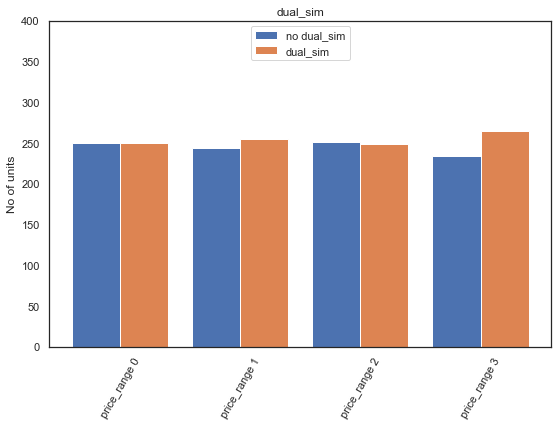

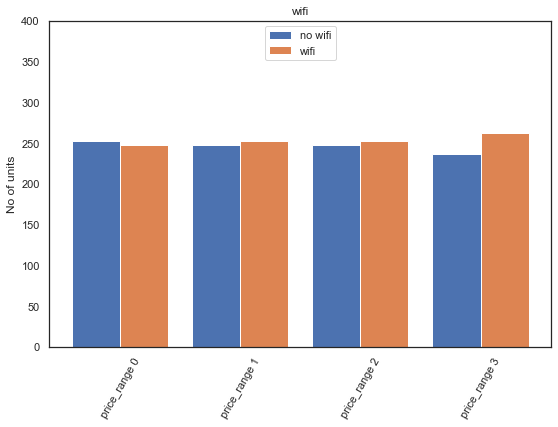

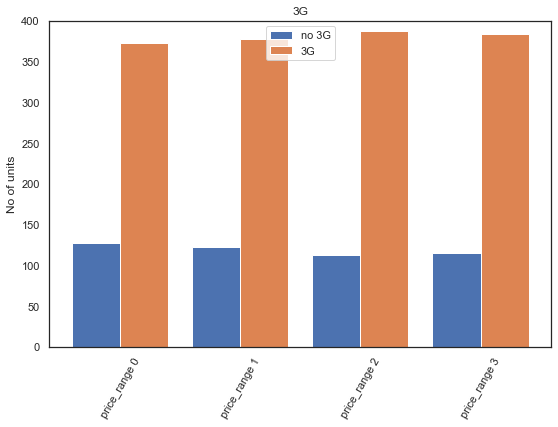

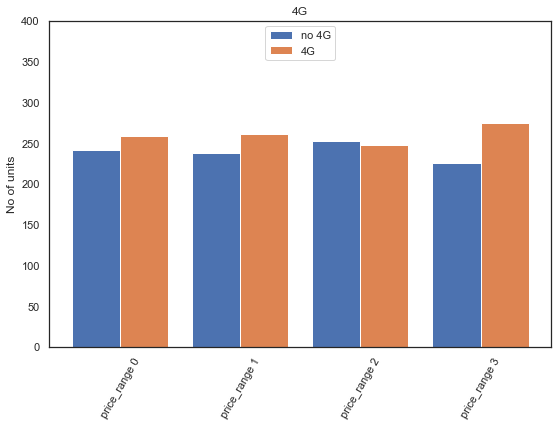

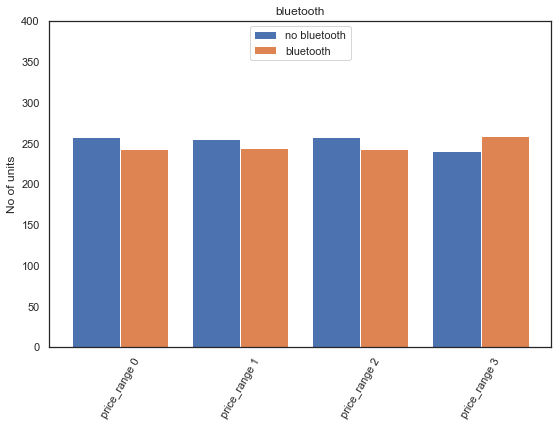

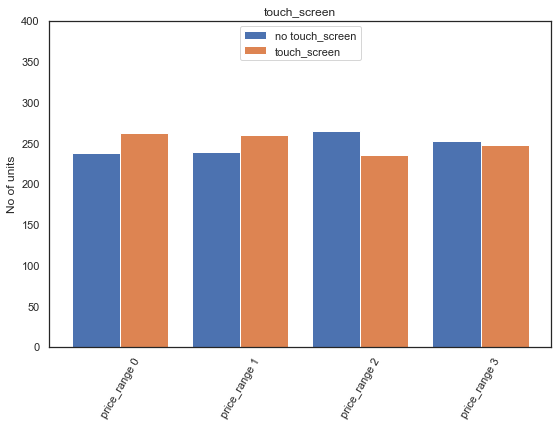

In [634]:
# Creating df according to price_range
df_0 = df[df['price_range'] == 0]
df_1 = df[df['price_range'] == 1]
df_2 = df[df['price_range'] == 2]
df_3 = df[df['price_range'] == 3]


# Creating stacked bar charts for each categorical feature wrt price range
for col in categorical:
    if col!='cores':
      fig = plt.figure(figsize=(9, 6))
      ax = fig.gca()
      plt.bar(x=[-0.2,0.8,1.8,2.8], height = [df_0[col].value_counts().sort_index()[0],df_1[col].value_counts().sort_index()[0],df_2[col].value_counts().sort_index()[0],df_3[col].value_counts().sort_index()[0]],
              label = 'no '+col, width = 0.4)
      plt.bar(x=[0.2,1.2,2.2,3.2], height = [df_0[col].value_counts().sort_index()[1],df_1[col].value_counts().sort_index()[1],df_2[col].value_counts().sort_index()[1],df_3[col].value_counts().sort_index()[1]],
              label = col,width = 0.4)
      plt.title(col)
      plt.legend(fontsize = 11, loc = 'upper center')
      plt.xticks([0,1,2,3],['price_range 0','price_range 1','price_range 2','price_range 3'], rotation = 60)
      plt.ylabel('No of units')
      plt.ylim(0,400)

In [635]:
def minus(a):
    return len(df[df[a] == 0])
    
def intersect(lst):
    temp = df[df[lst[0]] == 0]
    for i in range (1,len(lst)):
        temp = temp[(temp[lst[i-1]] == 0) & (temp[lst[i]] == 0)]
    return len(temp)

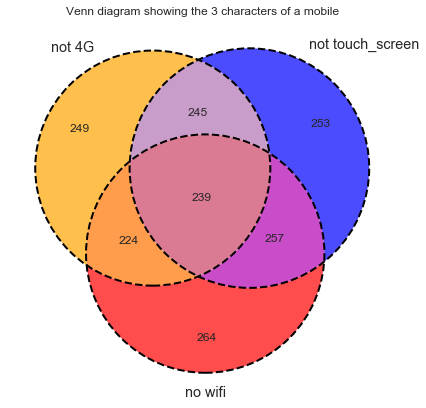

In [636]:
plt.figure(figsize=(25, 7))
abc = intersect(['4G','touch_screen','wifi'])
ab = intersect(['4G','touch_screen']) - abc
bc = intersect(['touch_screen','wifi']) - abc
ca = intersect(['4G','wifi']) - abc
a = minus('4G') - ab - ca - abc
b = minus('touch_screen') - bc - ab - abc
c = minus('wifi') - ca - bc - abc
venn3(subsets=(a, b, ab, c, ca, bc, abc), 
      set_labels=('not 4G', 'not touch_screen', 'no wifi'), 
      set_colors=("orange", "blue", "red"), alpha=0.7)
venn3_circles(subsets=(a, b, ab, c, ca, bc, abc),
              linestyle="dashed", linewidth=2)
plt.title('Venn diagram showing the 3 characters of a mobile')
plt.show()

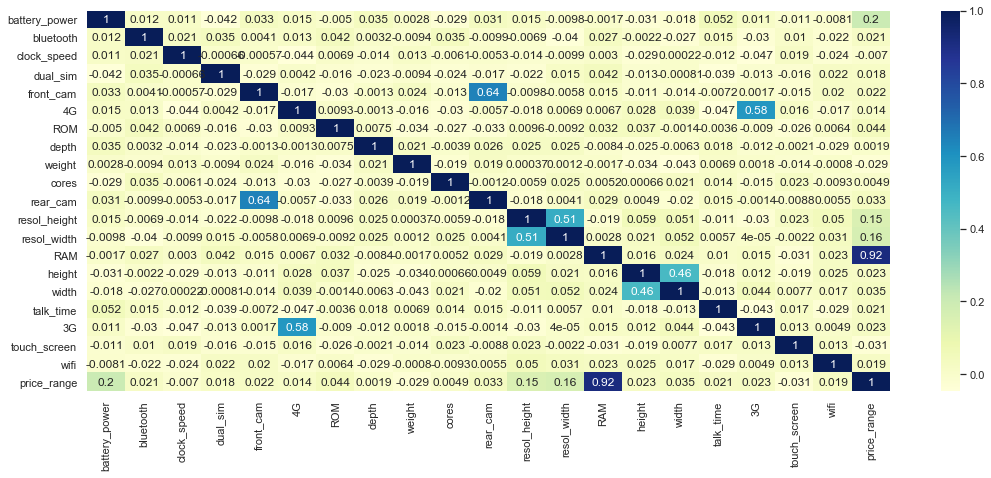

In [637]:
fig, ax = plt.subplots(figsize=(18,7))         # Sample figsize in inches
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

# Data PreProcessing

In [638]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [639]:
calc_vif(df[numerical])

,variables,VIF
0,depth,3.895832
1,ROM,3.926962
2,RAM,4.596016
3,talk_time,4.800848
4,resol_height,4.254352
5,battery_power,7.912981
6,resol_width,11.450749
7,width,4.269708
8,rear_cam,6.195289
9,front_cam,3.403928


We have to reduce our vifs 

In [640]:
#let us remove the weight column
df.drop(columns = 'weight',inplace=True)
numerical.remove('weight')

In [641]:
calc_vif(df[numerical])

,variables,VIF
0,depth,3.815082
1,ROM,3.885052
2,RAM,4.503686
3,talk_time,4.688265
4,resol_height,4.253689
5,battery_power,7.518759
6,resol_width,10.964003
7,width,4.267947
8,rear_cam,6.149232
9,front_cam,3.402830


In [642]:
#length variable which gives us the diagonal lenght of the mobile
df['length'] = np.round(np.sqrt(df['width']**2 + df['height']**2))
df.drop(columns = ['height','width'],inplace = True)
numerical.append('length')
numerical.remove('width')
numerical.remove('height')

In [643]:
calc_vif(df[numerical])

,variables,VIF
0,depth,3.813416
1,ROM,3.858055
2,RAM,4.503590
3,talk_time,4.686591
4,resol_height,4.252511
5,battery_power,7.497457
6,resol_width,10.976364
7,rear_cam,6.130489
8,front_cam,3.402049
9,clock_speed,4.092159


In [644]:
df['resol_length'] = np.round(np.sqrt(df['resol_width']**2 + df['resol_height']**2))
df.drop(columns = ['resol_height','resol_width'],inplace = True)
numerical.append('resol_length')
numerical.remove('resol_width')
numerical.remove('resol_height')

In [645]:
calc_vif(df[numerical])

,variables,VIF
0,depth,3.809082
1,ROM,3.857476
2,RAM,4.482238
3,talk_time,4.668236
4,battery_power,7.480423
5,rear_cam,6.110185
6,front_cam,3.401508
7,clock_speed,4.078104
8,length,7.421052
9,resol_length,7.185796


highest Variance inflation factor got reduced to 7

In [646]:
df.head()

,battery_power,bluetooth,clock_speed,dual_sim,front_cam,4G,ROM,depth,cores,rear_cam,RAM,talk_time,3G,touch_screen,wifi,price_range,length,resol_length
0,842.0,0.0,2.2,0.0,1.0,0.0,7.0,0.6,2.0,2.0,2549.0,19.0,0.0,0.0,1.0,1.0,11.0,756.0
1,1021.0,1.0,0.5,1.0,0.0,1.0,53.0,0.7,3.0,6.0,2631.0,7.0,1.0,1.0,0.0,2.0,17.0,2184.0
2,563.0,1.0,0.5,1.0,2.0,1.0,41.0,0.9,5.0,6.0,2603.0,9.0,1.0,1.0,0.0,2.0,11.0,2131.0
3,615.0,1.0,2.5,0.0,0.0,0.0,10.0,0.8,6.0,9.0,2769.0,11.0,1.0,0.0,0.0,2.0,18.0,2161.0
4,1821.0,1.0,1.2,0.0,13.0,1.0,44.0,0.6,2.0,14.0,1411.0,15.0,1.0,1.0,0.0,1.0,8.0,1711.0


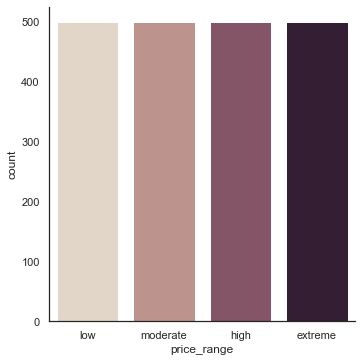

In [647]:
sns.catplot(x="price_range", kind="count", palette="ch:.25", data=df)
plt.xticks(ticks=[0,1,2,3],labels = ['low','moderate','high','extreme'])
plt.show()

# X and Y

In [648]:
independent = list(set(df.columns) - {dependent})

In [649]:
X = df[independent]
y = df[dependent]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Splitting into train and test data

In [650]:
from sklearn.model_selection import train_test_split

In [651]:
def printFeatureImportance(alg,scale=0):
    plt.figure(figsize=(20,9))
    try:
        imp = alg.feature_importances_
    except:
        imp = np.abs(alg.coef_[0])
    if scale:
        some_X = scaler.fit_transform(X)
    else:
        some_X = X
    feat_imp = pd.Series(imp, independent).sort_values(ascending=False)[:10]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [652]:
index = ['KNN','Decision Tree','Logistic Regression','Random Forest','AdaBoost','Gradient Boost','XGBoost']

In [653]:
BeforeTuning_train = {'Accuracy':[],'Precision':[],'Recall':[],'AUC_ROC':[]}
BeforeTuning_test = {'Accuracy':[],'Precision':[],'Recall':[],'AUC_ROC':[]}
AfterTuning_train = {'Accuracy':[],'Precision':[],'Recall':[],'AUC_ROC':[]}
AfterTuning_test = {'Accuracy':[],'Precision':[],'Recall':[],'AUC_ROC':[]}
Accuracy = {'Class-0':[],'Class-1':[],'Class-2':[],'Class-3':[],'Overall':[]}
def store_metrics(alg1, alg2, X_train, y_train, X_test, y_test):
    total = []
    for alg in [alg1,alg2]:
        for X,y in [(X_train, y_train), (X_test, y_test)]:
            y_pred = alg.predict(X)
            total.append(alg.score(X,y))
            total.append(precision_score(y,y_pred,average='micro'))
            total.append(recall_score(y,y_pred,average='micro'))
            total.append(roc_auc_score(y,alg.predict_proba(X), multi_class='ovr',average='weighted'))
    lists = [BeforeTuning_train,BeforeTuning_test,AfterTuning_train,AfterTuning_test]
    ind = 0
    for i in range(4):
        lists[i]['Accuracy'].append(str(round(total[ind]*100,2))+'%')
        lists[i]['Precision'].append(round(total[ind+1],3))
        lists[i]['Recall'].append(round(total[ind+2],3))
        lists[i]['AUC_ROC'].append(round(total[ind+3],3))
        ind +=4
    cm = confusion_matrix(y_test,alg2.predict(X_test))
    keys = list(Accuracy.keys())
    for i in range(4):
        Accuracy[keys[i]].append(str(round(max(list(cm[0:,i]))/sum(list(cm[0:,i]))*100,2))+'%')
    Accuracy[keys[4]].append(str(round(alg2.score(X_test, y_test)*100,2))+'%')

In [654]:
def print_metrics(n):
    tot = [AfterTuning_train,AfterTuning_test]
    for i in [0,1]:
        if i:
            print('\033[1m'+'For testing data: '+'\033[0m')
        else:
            print('\033[1m'+'For training data:'+'\033[0m')
        for met in ['Accuracy','Precision','Recall','AUC_ROC']:
            print('\t',met,': \t',tot[i][met][n])

In [655]:
def roc_plot(y_test,y_prob_pred):
    fpr = {}
    tpr = {}
    thresh ={}

    n_class = 4

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob_pred[:,i], pos_label=i)

    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
    plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=300)

# KNN

In [656]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [657]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [658]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [659]:
knn.score(X_test,y_test)

0.915

In [660]:
#finding optimal n
best = knn.score(X_test,y_test)
n = 10
for i in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    present = knn.score(X_test,y_test)
    if best < present:
        best,n = present,i

In [661]:
#best n value is
n

18

In [662]:
knn_best = KNeighborsClassifier(n_neighbors=n)
knn_best.fit(X_train,y_train)
knn_pred = knn_best.predict(X_test)

In [663]:
knn_best.score(X_test,y_test)

0.9375

In [664]:
confusion_matrix(y_test,knn_best.predict(X_test))

array([[100,   4,   0,   0],
       [  3,  84,   1,   0],
       [  0,   3, 100,   5],
       [  0,   0,   9,  91]], dtype=int64)

In [665]:
print(classification_report(y_test,knn_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       104
         1.0       0.92      0.95      0.94        88
         2.0       0.91      0.93      0.92       108
         3.0       0.95      0.91      0.93       100

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



In [666]:
store_metrics(knn,knn_best,X_train,y_train,X_test,y_test)
print_metrics(0)

For training data:
	 Accuracy : 	 92.43%
	 Precision : 	 0.924
	 Recall : 	 0.924
	 AUC_ROC : 	 0.995
For testing data: 
	 Accuracy : 	 93.75%
	 Precision : 	 0.938
	 Recall : 	 0.938
	 AUC_ROC : 	 0.994


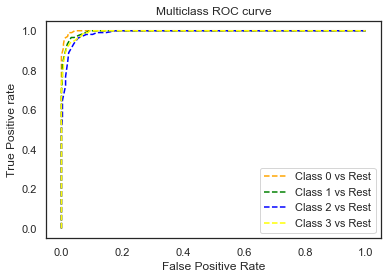

In [667]:
y_prob_pred = knn_best.predict_proba(X_test)
roc_plot(y_test,y_prob_pred)

# Decision Trees

In [668]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
dt = DecisionTreeClassifier(random_state = 0)

In [669]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [670]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [671]:
dt.score(X_test,y_test)

0.855

In [672]:
params = {
        'criterion' : ['gini', 'entropy'],
        'splitter' : ['best','random'],
        'max_depth' : [5,10,20,30,40,None],
        'min_samples_split' : Integer(2,7),
        'min_samples_leaf' : Integer(1,5),
        'max_features' : [None,'auto', 'sqrt', 'log2'],
        'random_state' : [0]
}

In [673]:
bayes_search = BayesSearchCV(estimator=dt, 
                           search_spaces=params, 
                           cv=3, n_jobs=-1, scoring = "accuracy")

In [674]:
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=3, error_score='raise',
              estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                               criterion='gini', max_depth=None,
                                               max_features=None,
                                               max_leaf_nodes=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=2,
                                               min_weight_fraction_leaf=0.0,
                                               presort='deprecated',
                                               random_state=0,
                                               splitter='best'),
              fit_p...
              scoring='accuracy',
              search_spaces={'criterion': ['gini', 

In [675]:
bayes_search.best_params_

OrderedDict([('criterion', 'entropy'),
             ('max_depth', 30),
             ('max_features', None),
             ('min_samples_leaf', 5),
             ('min_samples_split', 2),
             ('random_state', 0),
             ('splitter', 'best')])

In [676]:
bayes_search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [677]:
dt_best = bayes_search.best_estimator_

In [678]:
dt_best.score(X_test,y_test)

0.8725

In [679]:
confusion_matrix(y_test,dt_best.predict(X_test))

array([[94, 10,  0,  0],
       [ 6, 74,  8,  0],
       [ 0,  8, 89, 11],
       [ 0,  0,  8, 92]], dtype=int64)

In [680]:
print(classification_report(y_test,dt_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92       104
         1.0       0.80      0.84      0.82        88
         2.0       0.85      0.82      0.84       108
         3.0       0.89      0.92      0.91       100

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [681]:
store_metrics(dt,dt_best,X_train,y_train,X_test,y_test)
print_metrics(1)

For training data:
	 Accuracy : 	 95.56%
	 Precision : 	 0.956
	 Recall : 	 0.956
	 AUC_ROC : 	 0.998
For testing data: 
	 Accuracy : 	 87.25%
	 Precision : 	 0.872
	 Recall : 	 0.872
	 AUC_ROC : 	 0.948


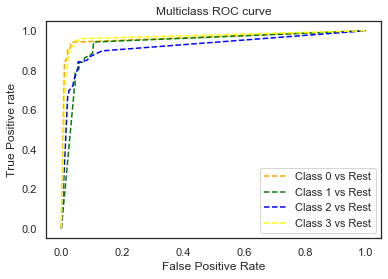

In [682]:
y_prob_pred = dt_best.predict_proba(X_test)
roc_plot(y_test,y_prob_pred)

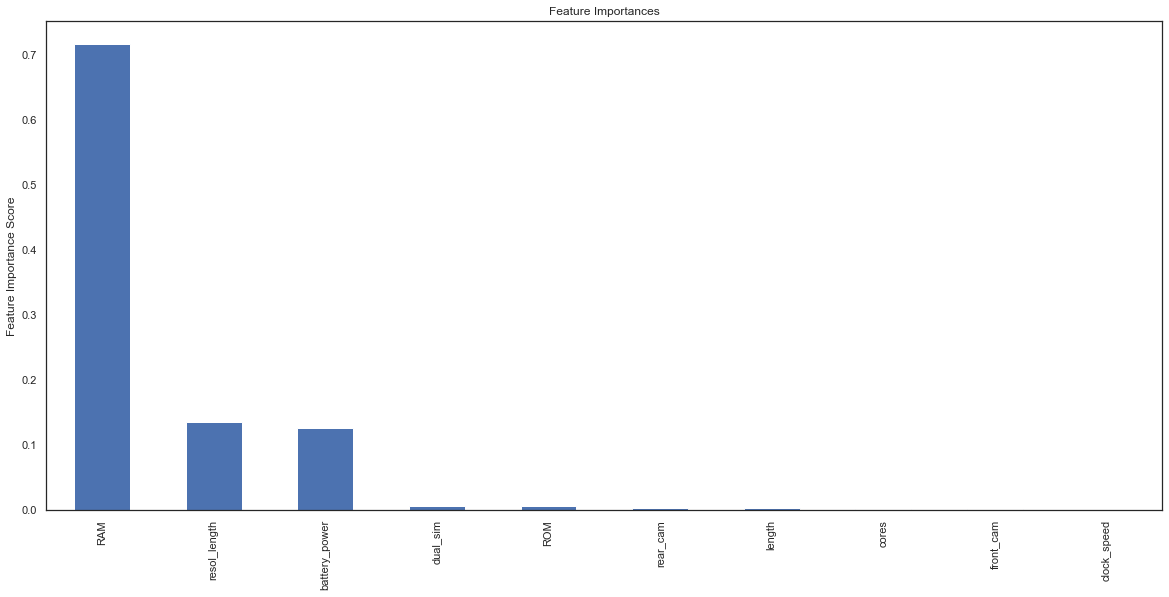

In [683]:
printFeatureImportance(dt_best)

# Logistic Regression

In [684]:
from sklearn.linear_model import LogisticRegression

X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [685]:
lr = LogisticRegression(random_state=0)

In [686]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [687]:
lr.score(X_test,y_test)

0.8925

In [688]:
params = {
    'C' : [0.001,0.01,0.1,1,10],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [689]:
bayes_search = BayesSearchCV(estimator=lr, 
                           search_spaces=params, 
                           cv=3, n_jobs=-1, scoring = "accuracy")

In [690]:
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=3, error_score='raise',
              estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                           fit_intercept=True,
                                           intercept_scaling=1, l1_ratio=None,
                                           max_iter=100, multi_class='auto',
                                           n_jobs=None, penalty='l2',
                                           random_state=0, solver='lbfgs',
                                           tol=0.0001, verbose=0,
                                           warm_start=False),
              fit_params=None, iid='deprecated', n_iter=50, n_jobs=-1,
              n_points=1, optimizer_kwargs=None, pre_dispatch='2*n_jobs',
              random_state=None, refit=True, return_train_score=False,
              scoring='accuracy',
              search_spaces={'C': [0.001, 0.01, 0.1, 1, 10],
                             'solver': ['newton-cg', 'lbfgs', 'liblinear',


In [691]:
bayes_search.best_params_

OrderedDict([('C', 10.0), ('solver', 'saga')])

In [692]:
bayes_search.best_estimator_

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [693]:
lr_best = bayes_search.best_estimator_

In [694]:
lr_best.score(X_test,y_test)

0.93

In [695]:
store_metrics(lr,lr_best,X_train,y_train,X_test,y_test)

In [696]:
confusion_matrix(y_test,lr_best.predict(X_test))

array([[97,  7,  0,  0],
       [ 2, 85,  1,  0],
       [ 0,  4, 96,  8],
       [ 0,  0,  6, 94]], dtype=int64)

In [697]:
print(classification_report(y_test,lr_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96       104
         1.0       0.89      0.97      0.92        88
         2.0       0.93      0.89      0.91       108
         3.0       0.92      0.94      0.93       100

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



In [698]:
print_metrics(2)

For training data:
	 Accuracy : 	 94.99%
	 Precision : 	 0.95
	 Recall : 	 0.95
	 AUC_ROC : 	 0.997
For testing data: 
	 Accuracy : 	 93.0%
	 Precision : 	 0.93
	 Recall : 	 0.93
	 AUC_ROC : 	 0.996


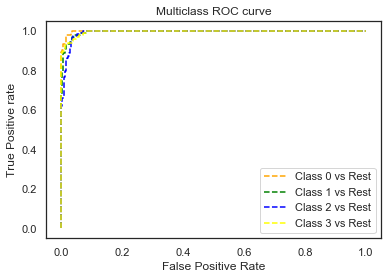

In [699]:
y_prob_pred = lr_best.predict_proba(X_test)
roc_plot(y_test,y_prob_pred)

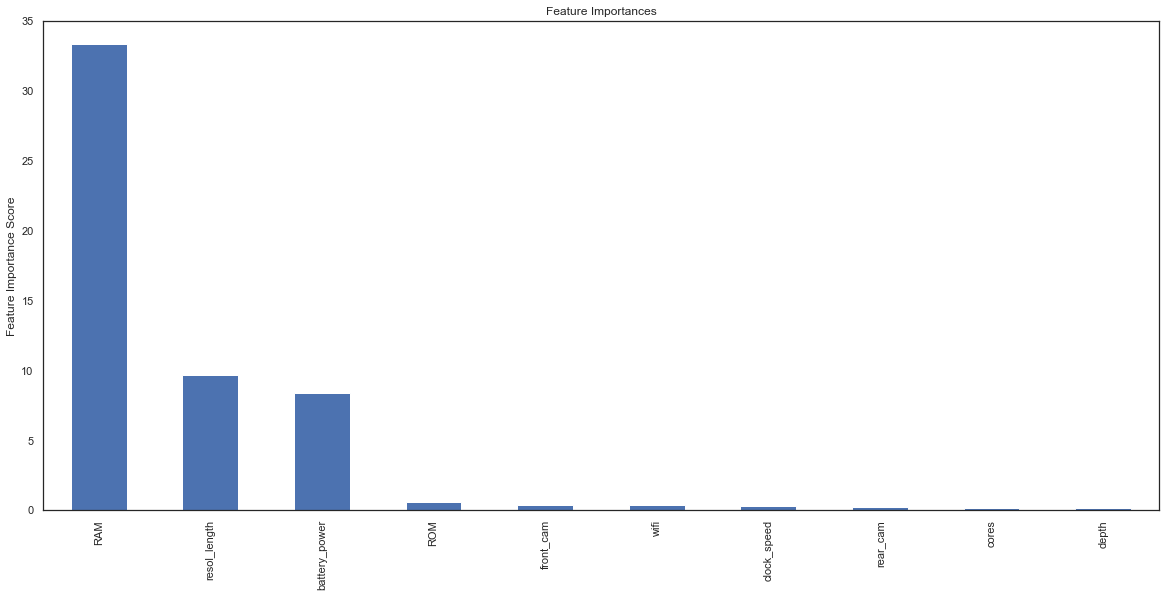

In [700]:
printFeatureImportance(lr_best)

# Random Forest

In [701]:
from sklearn.ensemble import RandomForestClassifier

In [702]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [703]:
rf = RandomForestClassifier(random_state = 0)

In [704]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [705]:
rf.score(X_test, y_test)

0.875

In [706]:
params = {
    'n_estimators' : list(range(100,1501,200)),
    'min_samples_leaf' : list(range(1,32,6)),
    'min_samples_split' : list(range(2,5)),
    'criterion' : ['gini','entropy'],
    'max_features' : ['auto','sqrt','log2'],
    'max_samples' : Real(0.00001,0.999)
}

In [707]:
bayes_search = BayesSearchCV(estimator=rf, 
                           search_spaces=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "accuracy")

In [708]:
bayes_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


BayesSearchCV(cv=3, error_score='raise',
              estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                               class_weight=None,
                                               criterion='gini', max_depth=None,
                                               max_features='auto',
                                               max_leaf_nodes=None,
                                               max_samples=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=2,
                                               min_weight_fraction_leaf=0.0,
                                               n_estimators=100, n_jobs=...
              random_state=None, refit=True, return_train_score=False,
              scoring='accur

In [709]:
bayes_search.best_params_

OrderedDict([('criterion', 'entropy'),
             ('max_features', 'sqrt'),
             ('max_samples', 0.9891669846262673),
             ('min_samples_leaf', 1),
             ('min_samples_split', 3),
             ('n_estimators', 900)])

In [710]:
bayes_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=0.9891669846262673,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [711]:
rf_best = bayes_search.best_estimator_

rf_best.score(X_test,y_test)

0.8875

In [712]:
confusion_matrix(y_test,rf_best.predict(X_test))

array([[99,  5,  0,  0],
       [ 6, 76,  6,  0],
       [ 0, 10, 89,  9],
       [ 0,  0,  9, 91]], dtype=int64)

In [713]:
print(classification_report(y_test,rf_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95       104
         1.0       0.84      0.86      0.85        88
         2.0       0.86      0.82      0.84       108
         3.0       0.91      0.91      0.91       100

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



In [714]:
store_metrics(rf,rf_best,X_train,y_train,X_test,y_test)
print_metrics(3)

For training data:
	 Accuracy : 	 100.0%
	 Precision : 	 1.0
	 Recall : 	 1.0
	 AUC_ROC : 	 1.0
For testing data: 
	 Accuracy : 	 88.75%
	 Precision : 	 0.888
	 Recall : 	 0.888
	 AUC_ROC : 	 0.986


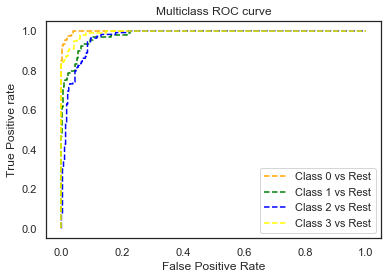

In [715]:
y_prob_pred = rf_best.predict_proba(X_test)
roc_plot(y_test,y_prob_pred)

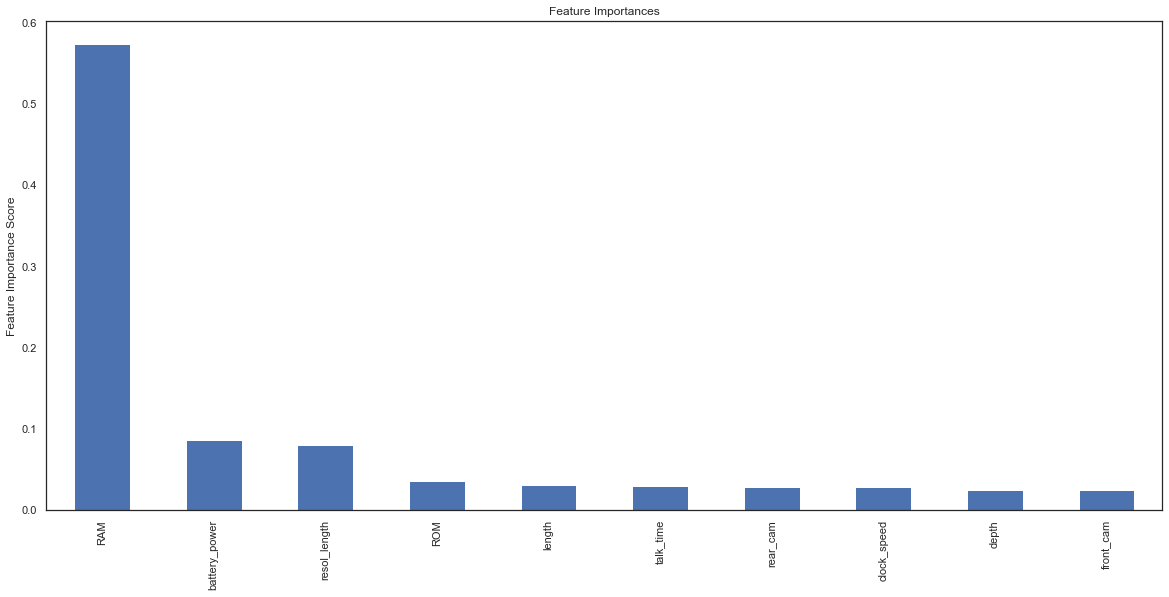

In [716]:
printFeatureImportance(rf_best)

# AdaBoost

In [717]:
from sklearn.ensemble import AdaBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [718]:
ab = AdaBoostClassifier(base_estimator = dt_best, learning_rate = 1, random_state = 0)

In [719]:
ab.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=30,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=5,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                      

In [720]:
ab.score(X_test,y_test)

0.9025

In [721]:
params = {
    'learning_rate' : [0.1,1,10],
    'n_estimators' : list(range(50,251,25))
}

In [722]:
bayes_search = BayesSearchCV(estimator=ab, 
                           search_spaces=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = 'accuracy')

In [723]:
bayes_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished


BayesSearchCV(cv=3, error_score='raise',
              estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                           base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                 class_weight=None,
                                                                                 criterion='entropy',
                                                                                 max_depth=30,
                                                                                 max_features=None,
                                                                                 max_leaf_nodes=None,
                                                                                 min_impurity_decrease=0.0,
                                                                                 min_impurity_split=None,
                                                                                 min_s

In [724]:
bayes_search.best_params_

OrderedDict([('learning_rate', 0.1), ('n_estimators', 200)])

In [725]:
bayes_search.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=30,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=5,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                      

In [726]:
ab_best = bayes_search.best_estimator_
ab_best.score(X_test, y_test)

0.905

In [727]:
confusion_matrix(y_test,ab_best.predict(X_test))

array([[98,  6,  0,  0],
       [ 5, 79,  4,  0],
       [ 0,  8, 90, 10],
       [ 0,  0,  5, 95]], dtype=int64)

In [728]:
print(classification_report(y_test,ab_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       104
         1.0       0.85      0.90      0.87        88
         2.0       0.91      0.83      0.87       108
         3.0       0.90      0.95      0.93       100

    accuracy                           0.91       400
   macro avg       0.90      0.91      0.90       400
weighted avg       0.91      0.91      0.90       400



In [729]:
store_metrics(ab,ab_best,X_train,y_train,X_test,y_test)
print_metrics(4)

For training data:
	 Accuracy : 	 100.0%
	 Precision : 	 1.0
	 Recall : 	 1.0
	 AUC_ROC : 	 1.0
For testing data: 
	 Accuracy : 	 90.5%
	 Precision : 	 0.905
	 Recall : 	 0.905
	 AUC_ROC : 	 0.991


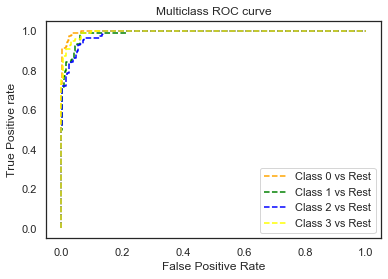

In [730]:
y_prob_pred = ab_best.predict_proba(X_test)
roc_plot(y_test,y_prob_pred)

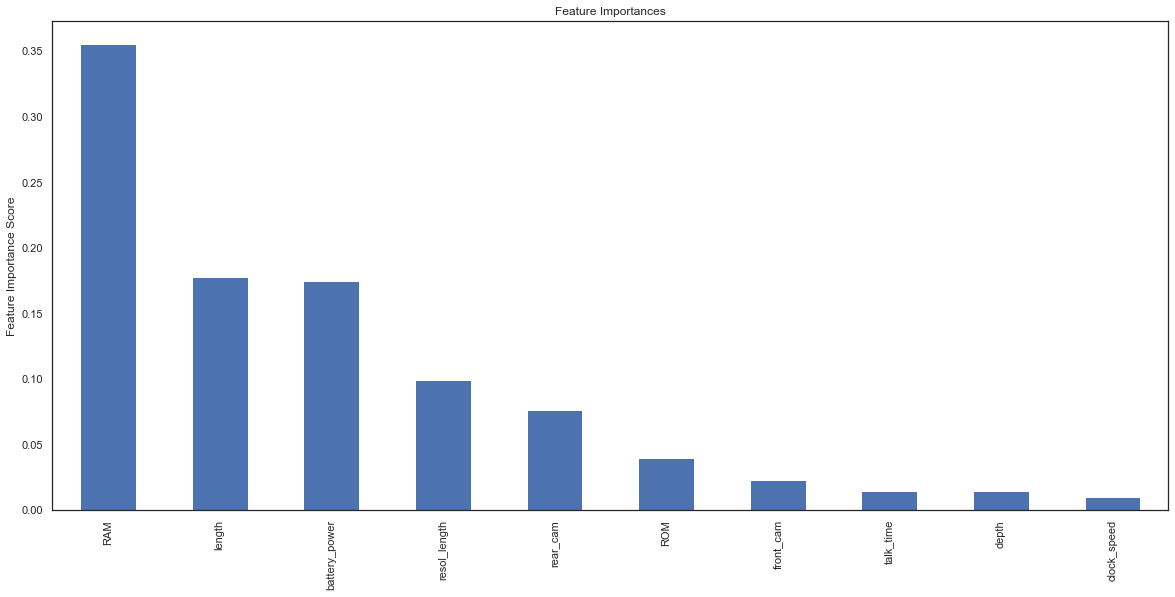

In [731]:
printFeatureImportance(ab_best)

# Gradient Boost

In [732]:
from sklearn.ensemble import GradientBoostingClassifier

In [733]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [734]:
gb = GradientBoostingClassifier(random_state = 0)

In [735]:
gb.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [736]:
gb.score(X_test,y_test)

0.895

In [737]:
params = {'n_estimators' : list(range(100,1001,50)),
          'max_depth' : list(range(1,11)),
          'learning_rate' : Real(0.00001,1),
          'max_features' : ['sqrt','auto',None],
          'min_samples_split' : list(range(2,6)),
          }

In [738]:
bayes_search = BayesSearchCV(estimator=gb, 
                           search_spaces=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "accuracy")

In [739]:
bayes_search.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


BayesSearchCV(cv=3, error_score='raise',
              estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                   criterion='friedman_mse',
                                                   init=None, learning_rate=0.1,
                                                   loss='deviance', max_depth=3,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                                                   n_iter...
    

In [740]:
bayes_search.best_params_

OrderedDict([('learning_rate', 0.5161140178803887),
             ('max_depth', 1),
             ('max_features', None),
             ('min_samples_split', 2),
             ('n_estimators', 1000)])

In [741]:
bayes_search.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5161140178803887, loss='deviance',
                           max_depth=1, max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [742]:
gb_best = bayes_search.best_estimator_
gb_best.score(X_test,y_test)

0.905

In [743]:
confusion_matrix(y_test,gb_best.predict(X_test))

array([[97,  7,  0,  0],
       [ 5, 78,  5,  0],
       [ 0,  4, 97,  7],
       [ 0,  0, 10, 90]], dtype=int64)

In [744]:
print(classification_report(y_test,gb_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       104
         1.0       0.88      0.89      0.88        88
         2.0       0.87      0.90      0.88       108
         3.0       0.93      0.90      0.91       100

    accuracy                           0.91       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.91      0.91      0.91       400



In [745]:
store_metrics(gb,gb_best,X_train,y_train,X_test,y_test)
print_metrics(5)

For training data:
	 Accuracy : 	 100.0%
	 Precision : 	 1.0
	 Recall : 	 1.0
	 AUC_ROC : 	 1.0
For testing data: 
	 Accuracy : 	 90.5%
	 Precision : 	 0.905
	 Recall : 	 0.905
	 AUC_ROC : 	 0.991


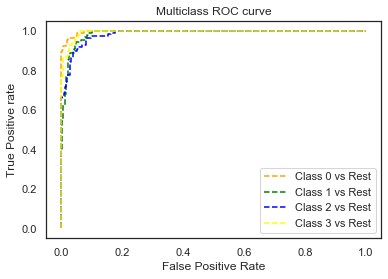

In [746]:
y_prob_pred = gb_best.predict_proba(X_test)
roc_plot(y_test,y_prob_pred)

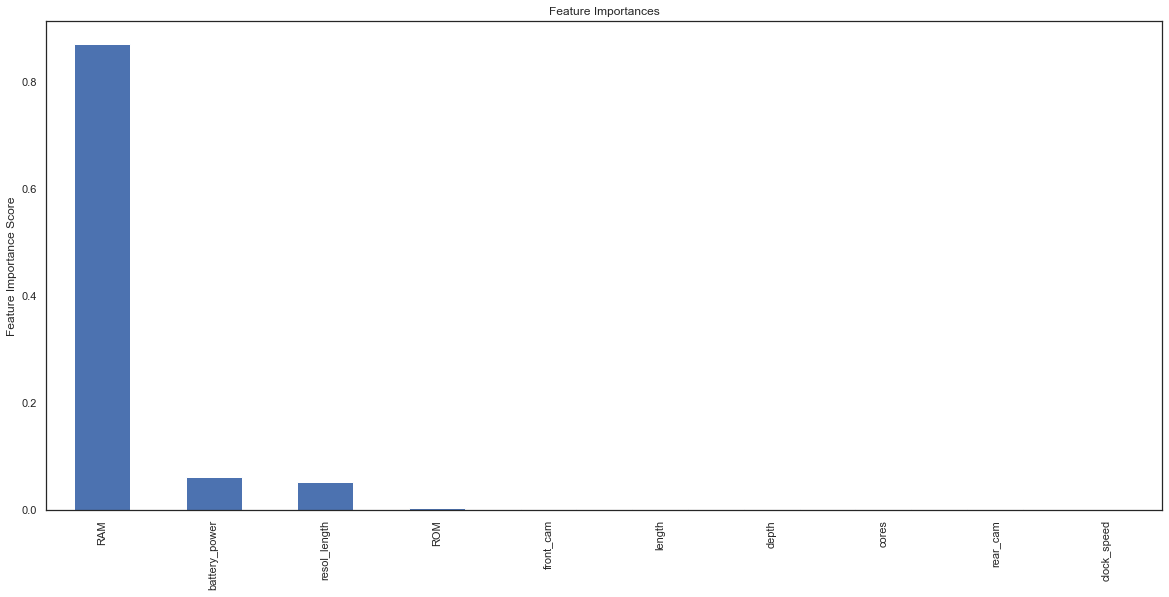

In [747]:
printFeatureImportance(gb_best)

# XG Boost

In [748]:
from xgboost import XGBClassifier

In [749]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [750]:
xg = XGBClassifier(random_state = 0)

In [751]:
xg.fit(X_train,y_train)

[14:42:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [752]:
xg.score(X_test,y_test)

0.92

In [753]:
params = {
    'booster' : ['gbtree', 'gblinear','dart'],
    'learning_rate' : Real(0.0001,1),
    'n_estimators' : list(range(100,501,50)),
    'gamma' : list(range(10,51,10)),
    'min_child_weight' : list(range(5,26,5)),
    'lambda' :Integer(1,5) ,
    'alpha' : Integer(0,4)
}

In [754]:
bayes_search = BayesSearchCV(estimator=xg, 
                           search_spaces=params, 
                           cv=3, n_jobs=-1,verbose=1, scoring = 'accuracy')

In [755]:
bayes_search.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   59.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   48.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


[14:48:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:48:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


BayesSearchCV(cv=3, error_score='raise',
              estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                      colsample_bylevel=1, colsample_bynode=1,
                                      colsample_bytree=1,
                                      enable_categorical=False, gamma=0,
                                      gpu_id=-1, importance_type=None,
                                      interaction_constraints='',
                                      learning_rate=0.300000012,
                                      max_delta_step=0, max_depth=6,
                                      min_child_weight=1, missing=nan,
                                      monotone_constraints...
              search_spaces={'alpha': Integer(low=0, high=4, prior='uniform', transform='normalize'),
                             'booster': ['gbtree', 'gblinear', 'dart'],
                             'gamma': [10, 20, 30, 40, 50],
                             'lambda': 

In [756]:
bayes_search.best_params_

OrderedDict([('alpha', 4),
             ('booster', 'gblinear'),
             ('gamma', 10),
             ('lambda', 1),
             ('learning_rate', 1.0),
             ('min_child_weight', 5),
             ('n_estimators', 500)])

In [757]:
xg_best = bayes_search.best_estimator_
xg_best.score(X_test, y_test)

0.9325

In [758]:
confusion_matrix(y_test,xg_best.predict(X_test))

array([[97,  7,  0,  0],
       [ 2, 84,  2,  0],
       [ 0,  3, 95, 10],
       [ 0,  0,  3, 97]], dtype=int64)

In [759]:
print(classification_report(y_test,xg_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96       104
         1.0       0.89      0.95      0.92        88
         2.0       0.95      0.88      0.91       108
         3.0       0.91      0.97      0.94       100

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



In [760]:
store_metrics(xg,xg_best,X_train,y_train,X_test,y_test)
print_metrics(6)

For training data:
	 Accuracy : 	 94.43%
	 Precision : 	 0.944
	 Recall : 	 0.944
	 AUC_ROC : 	 0.997
For testing data: 
	 Accuracy : 	 93.25%
	 Precision : 	 0.932
	 Recall : 	 0.932
	 AUC_ROC : 	 0.996


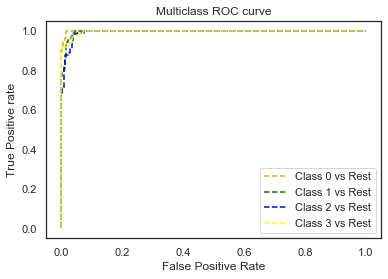

In [761]:
y_prob_pred = xg_best.predict_proba(X_test)
roc_plot(y_test,y_prob_pred)

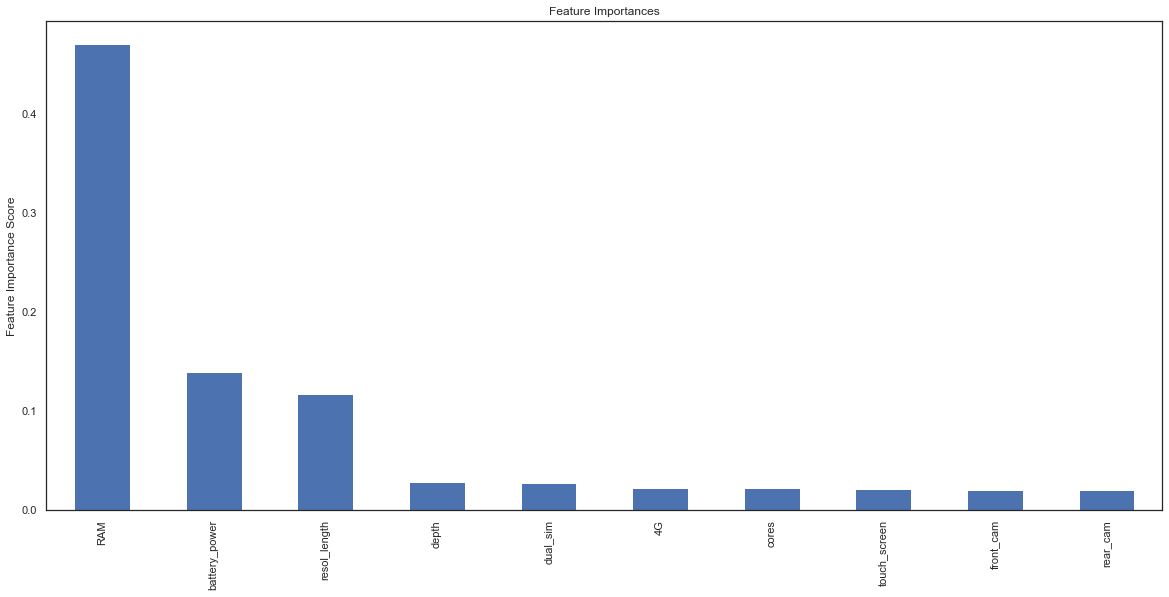

In [762]:
printFeatureImportance(xg)

# Acuuracy Analysis

In [763]:
cols = pd.MultiIndex.from_tuples((('Train Data', 'Accuracy'),('Train Data', 'Precision'),('Train Data', 'Recall'),('Train Data', 'AUC_ROC'),('Test Data', 'Accuracy'),('Test Data', 'Precision'),('Test Data', 'Recall'),('Test Data', 'AUC_ROC')))
before_tuning_df = pd.DataFrame(list(zip(BeforeTuning_train['Accuracy'],BeforeTuning_train['Precision'],
                                 BeforeTuning_train['Recall'],BeforeTuning_train['AUC_ROC'],
                                 BeforeTuning_test['Accuracy'],BeforeTuning_test['Precision'],
                                 BeforeTuning_test['Recall'],BeforeTuning_test['AUC_ROC'])),
                        columns = cols, index = index)

In [764]:
before_tuning_df

Train Data                          Test Data                         
                      Accuracy Precision Recall AUC_ROC  Accuracy Precision Recall AUC_ROC
KNN                     92.37%     0.924  0.924   0.995    93.25%     0.932  0.932   0.994
Decision Tree           100.0%     1.000  1.000   1.000     85.5%     0.855  0.855   0.903
Logistic Regression     92.68%     0.927  0.927   0.992    89.25%     0.892  0.892   0.990
Random Forest           100.0%     1.000  1.000   1.000     87.5%     0.875  0.875   0.982
AdaBoost                100.0%     1.000  1.000   1.000    90.25%     0.902  0.902   0.987
Gradient Boost          99.69%     0.997  0.997   1.000     89.5%     0.895  0.895   0.988
XGBoost                 100.0%     1.000  1.000   1.000     92.0%     0.920  0.920   0.992

In [765]:
cols = pd.MultiIndex.from_tuples((('Train Data', 'Accuracy'),('Train Data', 'Precision'),('Train Data', 'Recall'),('Train Data', 'AUC_ROC'),('Test Data', 'Accuracy'),('Test Data', 'Precision'),('Test Data', 'Recall'),('Test Data', 'AUC_ROC')))
after_tuning_df = pd.DataFrame(list(zip(AfterTuning_train['Accuracy'],AfterTuning_train['Precision'],
                                 AfterTuning_train['Recall'],AfterTuning_train['AUC_ROC'],
                                 AfterTuning_test['Accuracy'],AfterTuning_test['Precision'],
                                 AfterTuning_test['Recall'],AfterTuning_test['AUC_ROC'])),
                        columns = cols, index = index)

In [766]:
after_tuning_df

Train Data                          Test Data                         
                      Accuracy Precision Recall AUC_ROC  Accuracy Precision Recall AUC_ROC
KNN                     92.43%     0.924  0.924   0.995    93.75%     0.938  0.938   0.994
Decision Tree           95.56%     0.956  0.956   0.998    87.25%     0.872  0.872   0.948
Logistic Regression     94.99%     0.950  0.950   0.997     93.0%     0.930  0.930   0.996
Random Forest           100.0%     1.000  1.000   1.000    88.75%     0.888  0.888   0.986
AdaBoost                100.0%     1.000  1.000   1.000     90.5%     0.905  0.905   0.991
Gradient Boost          100.0%     1.000  1.000   1.000     90.5%     0.905  0.905   0.991
XGBoost                 94.43%     0.944  0.944   0.997    93.25%     0.932  0.932   0.996

In [767]:
cols = pd.MultiIndex.from_tuples(((' ', 'Class-0'),(' ', 'Class-1'),('Accuracy', 'Class-2'),(' ', 'Class-3'),(' ','Overall')))
Accuray_df = pd.DataFrame(list(zip(Accuracy['Class-0'],Accuracy['Class-1'],Accuracy['Class-2'],Accuracy['Class-3'],Accuracy['Overall'])),
                        columns = cols, index = index)

In [768]:
Accuray_df

Accuracy                
                    Class-0 Class-1  Class-2 Class-3 Overall
KNN                  97.09%  92.31%   90.91%  94.79%  93.75%
Decision Tree         94.0%  80.43%   84.76%  89.32%  87.25%
Logistic Regression  97.98%  88.54%    93.2%  92.16%   93.0%
Random Forest        94.29%  83.52%   85.58%   91.0%  88.75%
AdaBoost             95.15%  84.95%   90.91%  90.48%   90.5%
Gradient Boost        95.1%  87.64%   86.61%  92.78%   90.5%
XGBoost              97.98%  89.36%    95.0%  90.65%  93.25%

In [ ]:
fig, axs = plt.subplots(2, 3)
